# Custom Vision APIを使った手書き文字のOCR

このノートブックでは、Cognitive Service Computer Vision API を使って手書き文字のOCR を行います。

<hr>


## 1.  準備

[Azure Cognitive Services](https://www.microsoft.com/cognitive-services/en-us/computer-vision-api)にアクセスし、「Try for free」ボタンをクリックします。 

Microsoftアカウントを使用してサインインすると、Computer Vision APIのAPIキーを取得できます。

<img src="https://github.com/asashiho/Cognitive_Services_Vision/wiki/images/ocr1.png">


取得したAPIキーとエンドポイントを以下の変数に設定します。

In [8]:
# エンドポイント URL
_url = 'https://japaneast.api.cognitive.microsoft.com/vision/v1.0/RecognizeText'

# API キー
_key = 'xxxxx'

_maxNumRetries = 10

## 2. 必要なライブラリのインポート

In [2]:
import time, requests, cv2, operator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 


## 3. リクエストを処理するヘルパー関数

In [3]:
def processRequest( json, data, headers, params ):



    retries = 0
    result = None

    while True:
        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429:
            print( "Message: %s" % ( response.json() ) )
            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break
        elif response.status_code == 202:
            result = response.headers['Operation-Location']
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )
        break
        
    return result

##  4. OCRの結果を取得する関数    

In [4]:
def getOCRTextResult( operationLocation, headers ):

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            if retries <= _maxNumRetries:
                time.sleep(1)
                retries += 1
                continue
            else:
                print('Error: failed after retrying!')
                break
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

## 5. 処理結果を表示する関数

In [5]:
def showResultOnImage( result, img ):
    
    img = img[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, aspect='equal')

    lines = result['recognitionResult']['lines']

    for i in range(len(lines)):
        words = lines[i]['words']
        for j in range(len(words)):
            tl = (words[j]['boundingBox'][0], words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2], words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4], words[j]['boundingBox'][5])
            bl = (words[j]['boundingBox'][6], words[j]['boundingBox'][7])
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            line = Line2D(x, y, linewidth=3.5, color='red')
            ax.add_line(line)
            ax.text(tl[0], tl[1] - 2, '{:s}'.format(text),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

# 6. オリジナルの画像でOCRしてみよう

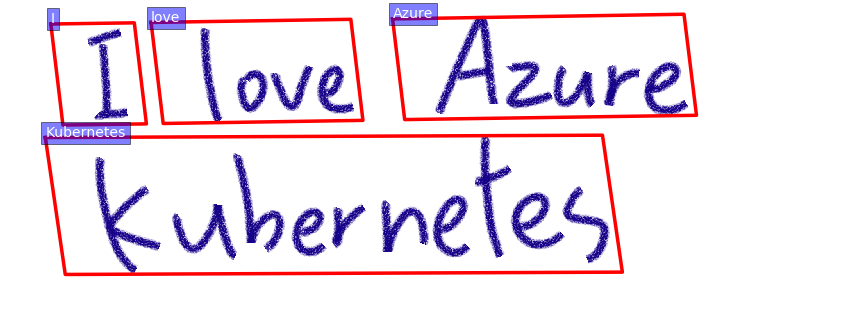

In [6]:
# 画像ファイルの読み込み
pathToFileInDisk = r'kubernetes.png'
with open(pathToFileInDisk, 'rb') as f:
    data = f.read()

# Computer Vision API のパラーメータ
params = {'handwriting' : 'true'}

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

operationLocation = processRequest(json, data, headers, params)

result = None
if (operationLocation != None):
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = _key
    while True:
        time.sleep(1)
        result = getOCRTextResult(operationLocation, headers)
        if result['status'] == 'Succeeded' or result['status'] == 'Failed':
            break

# 結果の表示
if result is not None and result['status'] == 'Succeeded':
    data8uint = np.frombuffer(data, np.uint8)
    
    img = cv2.cvtColor(cv2.imdecode(data8uint, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    showResultOnImage(result, img)

## 7. 画像のURLを指定してOCRしてみよう

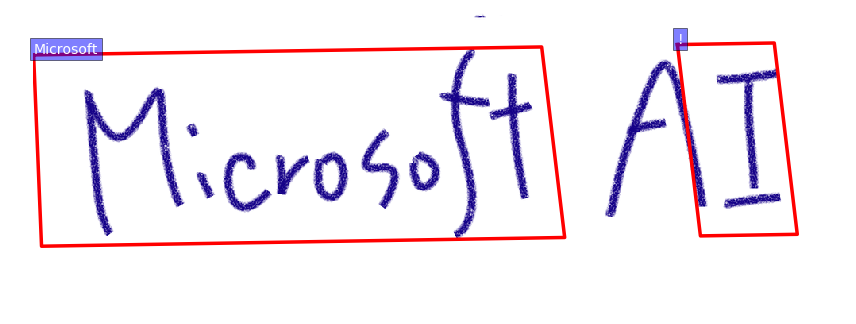

In [7]:
# 画像のURI
urlImage = 'https://cdn-ak.f.st-hatena.com/images/fotolife/d/dr_asa/20180914/20180914163428.png'
# Computer Vision API のパラメータ
params = { 'handwriting' : 'true'}

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json'

json = { 'url': urlImage }
data = None

result = None
operationLocation = processRequest(json, data, headers, params)
if (operationLocation != None):
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = _key
    while True:
        time.sleep(1)
        result = getOCRTextResult(operationLocation, headers)
        if result['status'] == 'Succeeded' or result['status'] == 'Failed':
            break

if result is not None and result['status'] == 'Succeeded':
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )
    showResultOnImage( result, img )

<hr>
詳細については：


https://docs.microsoft.com/en-us/azure/cognitive-services/Computer-vision/home
